In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision.transforms import ToTensor
import torchvision

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


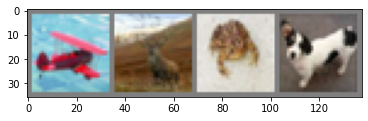

plane deer  frog  dog  


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
import ProtoNetBack
net = ProtoNetBack.ProtoNetBack(3)
model = net.layers


print(net.get_embedding_size(input_size=(3, 32, 32)))
print(net)

10
ProtoNetBack(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [6]:
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_accu = []
train_losses = []

for epoch in range(10):

    running_loss = 0.
    correct=0
    total=0
    batch_size = 100
      
    for i, data in enumerate(
              torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2), 0):
          
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
          
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        train_loss=running_loss/len(trainloader)
        accu=100.*correct/total

        train_accu.append(accu)
        train_losses.append(loss.item())
          
        print('[%d, %5d] loss: %.4f accuracy: %.2f' %(epoch + 1, (i+1)*batch_size, loss.item(), accu))

print('Finished Training')

torch.save(net, 'cifar10.pkl')

Streaming output truncated to the last 5000 lines.
[1,   200] loss: 2.2182 accuracy: 10.00
[1,   300] loss: 2.2039 accuracy: 11.67
[1,   400] loss: 2.1089 accuracy: 14.50
[1,   500] loss: 2.0924 accuracy: 17.20
[1,   600] loss: 1.9515 accuracy: 20.33
[1,   700] loss: 1.9414 accuracy: 21.43
[1,   800] loss: 1.8796 accuracy: 23.38
[1,   900] loss: 1.8789 accuracy: 24.22
[1,  1000] loss: 1.9616 accuracy: 24.50
[1,  1100] loss: 1.8150 accuracy: 25.09
[1,  1200] loss: 1.8629 accuracy: 25.58
[1,  1300] loss: 1.7814 accuracy: 26.38
[1,  1400] loss: 1.9151 accuracy: 26.43
[1,  1500] loss: 1.7391 accuracy: 26.47
[1,  1600] loss: 1.9340 accuracy: 26.69
[1,  1700] loss: 1.8552 accuracy: 27.12
[1,  1800] loss: 1.7179 accuracy: 27.33
[1,  1900] loss: 1.6826 accuracy: 28.05
[1,  2000] loss: 1.7428 accuracy: 28.50
[1,  2100] loss: 1.6248 accuracy: 29.14
[1,  2200] loss: 1.7792 accuracy: 29.32
[1,  2300] loss: 1.7265 accuracy: 29.83
[1,  2400] loss: 1.6490 accuracy: 30.12
[1,  2500] loss: 1.4814 accur

In [7]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 74 %
Accuracy of plane : 84 %
Accuracy of   car : 84 %
Accuracy of  bird : 64 %
Accuracy of   cat : 54 %
Accuracy of  deer : 78 %
Accuracy of   dog : 62 %
Accuracy of  frog : 73 %
Accuracy of horse : 82 %
Accuracy of  ship : 77 %
Accuracy of truck : 82 %
